# Maria Angelica Becerra
# Santiago Ospina
# Geraldin Carriazo

In [309]:
import io
import sys
PATH = '/home/epuerta/Academic/AI_DataAnalytics/SLF4SA/'
DIR_DATA = '../Data/'
sys.path.append(PATH) if PATH not in list(sys.path) else None
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing

from sklearn.pipeline import FeatureUnion
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.models import Sequential
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from nltk.corpus import stopwords

from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, precision_score

from logic.utils import Utils
from logic.classifiers import Classifiers
from logic.text_processing import TextProcessing
from logic.lexical_vectorizer import LexicalVectorizer
from root import DIR_RESULTS

from nltk import TweetTokenizer

# Variable initialization 

In [283]:
lang = 'es'
iteration = 10
fold = 10
classifiers = Classifiers.dict_classifiers
tp = TextProcessing(lang=lang)
lv = LexicalVectorizer(lang=lang, text_processing=tp)
ut = Utils(lang=lang, text_processing=tp)

# Import data

In [284]:
print('+ Import training...')
x, y = ut.get_data(file_name='tass2020_emotion_train')
print('+ Import test...')
x_eval, y_eval = ut.get_data(file_name='tass2020_emotion_dev')

+ Import training...
- Dataset size :(x: 5886 , y: 5886)
+ Import test...
- Dataset size :(x: 857 , y: 857)


# Feature extraction

In [285]:
x = lv.transform(x)
x_eval = lv.transform(x_eval)
print('- train:\n', sorted(Counter(y).items()))
print('- test: \n', sorted(Counter(y_eval).items()))

- train:
 [('anger ', 600), ('disgust ', 113), ('fear ', 67), ('joy ', 1270), ('others ', 2889), ('sadness ', 706), ('surprise ', 241)]
- test: 
 [('anger ', 87), ('disgust ', 16), ('fear ', 10), ('joy ', 185), ('others ', 421), ('sadness ', 103), ('surprise ', 35)]


# over sampling

In [264]:
k_fold = ShuffleSplit(n_splits=fold, test_size=0.25, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
ros_train = RandomOverSampler(random_state=1000)
x_train, y_train = ros_train.fit_resample(x_train, y_train)
x_test, y_test = ros_train.fit_resample(x_test, y_test)
print('- train:\n', sorted(Counter(y_train).items()))
print('- test:\n', sorted(Counter(y_test).items()))

- train:
 [('anger ', 2023), ('disgust ', 2023), ('fear ', 2023), ('joy ', 2023), ('others ', 2023), ('sadness ', 2023), ('surprise ', 2023)]
- test:
 [('anger ', 866), ('disgust ', 866), ('fear ', 866), ('joy ', 866), ('others ', 866), ('sadness ', 866), ('surprise ', 866)]


In [265]:
shape = x_train.shape

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_eval = scaler.transform(x_eval)

In [297]:
x_train = abs(x_train)
print(x_train)

[[0.04051981 0.86311817 0.05397495 ... 0.16207475 0.12619689 0.38215251]
 [0.04051981 0.62050436 0.69009941 ... 0.16207475 0.12619689 0.4260692 ]
 [0.04051981 0.62050436 0.54678283 ... 0.16207475 0.12619689 0.73600653]
 ...
 [0.04051981 0.62050436 0.01055942 ... 0.16207475 0.12619689 2.07869517]
 [0.04051981 0.42352631 0.41927706 ... 0.16207475 0.12619689 0.54676902]
 [0.04051981 4.50473711 0.21237748 ... 0.16207475 0.12619689 0.70823601]]


In [ ]:
lb = LabelEncoder()
y_train = lb.fit_transform([i for i in y_train])
y_eval = lb.transform([i for i in y_eval])
y_test = lb.transform([i for i in y_test])

In [299]:
labels = tf.keras.utils.to_categorical(y_train,7, dtype="float32")
print(labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


# NN Architecture

In [300]:
model = Sequential()
model.add(Embedding(5000,27))
model.add(LSTM(128,activation = "relu", return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1, activation = "relu"))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='sigmoid'))

In [301]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 27)          135000    
_________________________________________________________________
lstm_64 (LSTM)               (None, None, 128)         79872     
_________________________________________________________________
dropout_30 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
lstm_65 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_66 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_42 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_43 (Dense)             (None, 7)               

# Training

In [311]:
history = model.fit(x_train, labels, epochs=3,batch_size=32, verbose=2)

Epoch 1/3
443/443 - 63s - loss: 0.4043 - accuracy: 0.1995
Epoch 2/3
443/443 - 63s - loss: 0.3956 - accuracy: 0.2382
Epoch 3/3
443/443 - 63s - loss: 0.3947 - accuracy: 0.2373


# Result

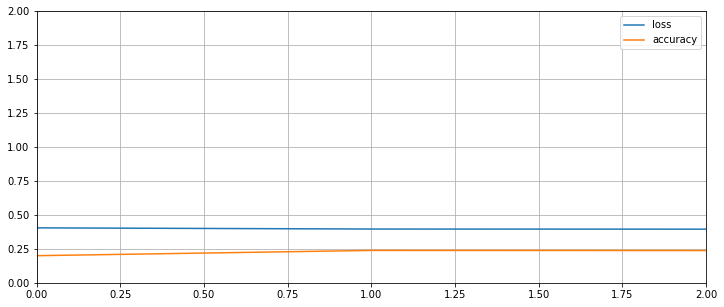

In [312]:
pd.DataFrame(history.history).plot(figsize=(12, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()